In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'new-plant-diseases-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F78313%2F182633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240130%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240130T035624Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c655cc72f3947f2fafdd7ad82a8ad02533ce7da8fab74704b8f25cbcb0f5d61cb7f91a002722b9a2ceadccb9d5a3ae984734cfbe93a4d0820d38547cfb728377a414d10e652d97faa09c26cc1780c239765d9d0bca6935748be90cd1e1fae462afee3df186dafdf8be96bf047f5e4adcf49b77ba6a12c50eab7c605baf53ce395e3d15fe4c5503107ce47ddf235e5057480b2f990d7c03fb7619d46abad95c5239f5a5d1da8f3de91d7a0304012c666617c42733d15348a166928fdb339821f51eb7ca77917f554a03106b9a872e40df552f318c00ff1208681542b3b3b608151faa981db19ae04f2c457892d1da48feb5905c0179572135b4004cc02fb1a80'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2897709187 bytes downloaded
Downloaded and uncompressed: new-plant-diseases-dataset
Data source import complete.


### Importing and downloading Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
import keras
#import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* I am checking the versions of libraries and frameworks because difference in versions between development and deployment envorinment, can cause issues.  Especially when using the model for inference and deployment on local environments or cloud services, may lead to issues. (Best is creating new virtual envorinment for the project use that envorinment in development and deployment but I am using Kaggle here so I have create new envorinment for this project. )

In [ ]:
print("numpy", np.__version__)
print("OpenCV ", cv2.__version__)
print("tensorflow", tf.__version__)

numpy 1.23.5
OpenCV  4.8.0
tensorflow 2.15.0


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
EPOCH = 8

### Working with Image Data

In [ ]:
# checking the directory
os.listdir('/kaggle/input/new-plant-diseases-dataset/')

['test',
 'new plant diseases dataset(augmented)',
 'New Plant Diseases Dataset(Augmented)']

In [ ]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
#test_dir = "/kaggle/input/new-plant-diseases-dataset/test/test"
diseases = os.listdir(train_dir)# printing the disease names
print(diseases)

['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___healthy', 'Apple___Black_rot', 'Squash___Powdery_mildew', 'Grape___Black_rot', 'Apple___Cedar_apple_rust', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___healthy', 'Potato___Late_blight', 'Tomato___Target_Spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Pepper,_bell___Bacterial_spot', 'Soybean___healthy', 'Tomato___Septoria_leaf_spot', 'Pepper,_bell___healthy', 'Apple___healthy', 'Strawberry___healthy', 'Tomato___healthy', 'Tomato___Bacterial_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Corn_(maize)___Northern_Leaf_Blight', 'Peach___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Strawberry___Leaf_scorch', 'Cherry_(including_sour)___Powdery_mildew', 'Blueberry___healthy', 'Raspberry___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___healthy', 'Apple___Apple_scab', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Early_blight', 'Cherry_(incl

In [ ]:
# How many different classes do we have?
print(len(diseases))

38


* In our case it will return 5 different classes

In [ ]:
# with this code:  TensorFlow will only output log messages with a severity level of 'WARNING' or higher.
tf.get_logger().setLevel('WARNING')

* The parameters you have specified in the ImageDataGenerator are used to apply various transformations to the input images during training. Here's a brief explanation of each parameter:

rescale: Scales the pixel values of the images by the specified factor. In this case, it is rescaling by 1/255.0, which normalizes the pixel values to the range [0, 1].

shear_range: Introduces shearing transformations to the images. Shearing shifts one part of the image in a direction, creating a sort of 'tilting' effect.

zoom_range: Applies random zooming in or out on the images. This helps the model become more robust to different scales of objects.

width_shift_range and height_shift_range: Perform random horizontal or vertical shifts on the images. This helps the model to generalize better to different positions of objects in the images.

fill_mode: Specifies the strategy to fill in newly created pixels during the transformations. "nearest" means that the nearest pixel value will be used for filling.

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")



validation_datagen =  keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)



In [ ]:
train_dir

'../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'

In [ ]:

# Define the generator instances
# generates batches of augmented data from the specified directory, allowing you to iterate over the training dataset during model training.
# handle large dataset and apply data augmentation methods
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",

)

val_data = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)




Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


* Testing datasets and checking their shape is right for training

In [ ]:
print("Number of batches in training generator:", len(train_data))
print("Number of batches in validation generator:", len(val_data))

Number of batches in training generator: 2197
Number of batches in validation generator: 550


In [ ]:
# get sample from training data generator
sample_batch = next(train_data)

# Extract images and labels from the batch
images, labels = sample_batch

# Print the shape of images and labels
print("Shape of images in the batch:", images.shape)
print("Shape of labels in the batch:", labels.shape)

Shape of images in the batch: (32, 224, 224, 3)
Shape of labels in the batch: (32, 38)


#### Visualize the data
*
Here are the first 12 images in the training dataset.

In [ ]:
# Retrieve a batch of images and labels
images, labels = next(train_data)

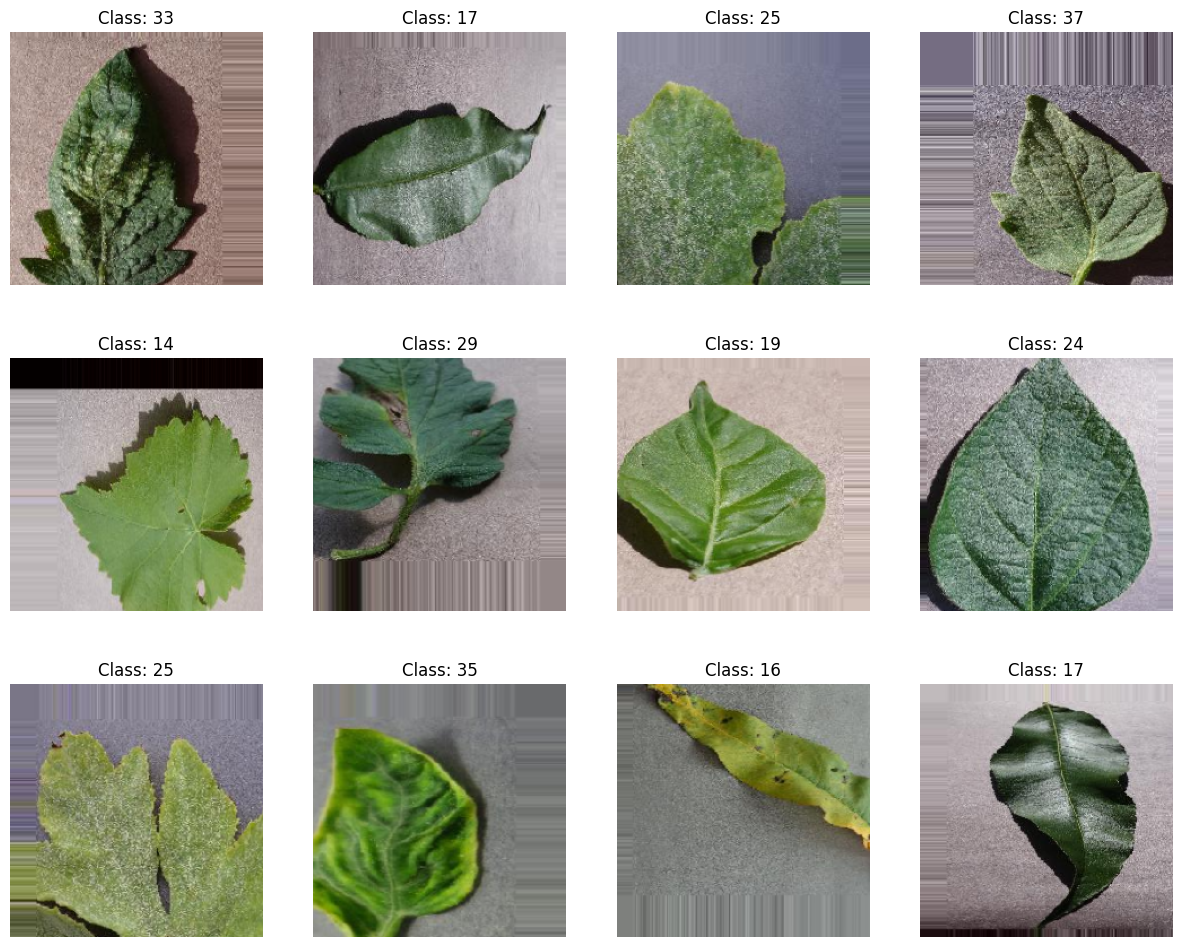

In [ ]:
# Display the images
plt.figure(figsize=(15, 12))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i].argmax()}")
    plt.axis("off")

plt.show()

In [ ]:
# Number of images for each disease
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Tomato_Yellow_Leaf_Curl_Virus,1961
Potato___healthy,1824
Apple___Black_rot,1987
Squash___Powdery_mildew,1736
Grape___Black_rot,1888
Apple___Cedar_apple_rust,1760
Tomato___Tomato_mosaic_virus,1790
Corn_(maize)___healthy,1859
Potato___Late_blight,1939
Tomato___Target_Spot,1827


Text(0.5, 1.0, 'Images per each class of plant disease')

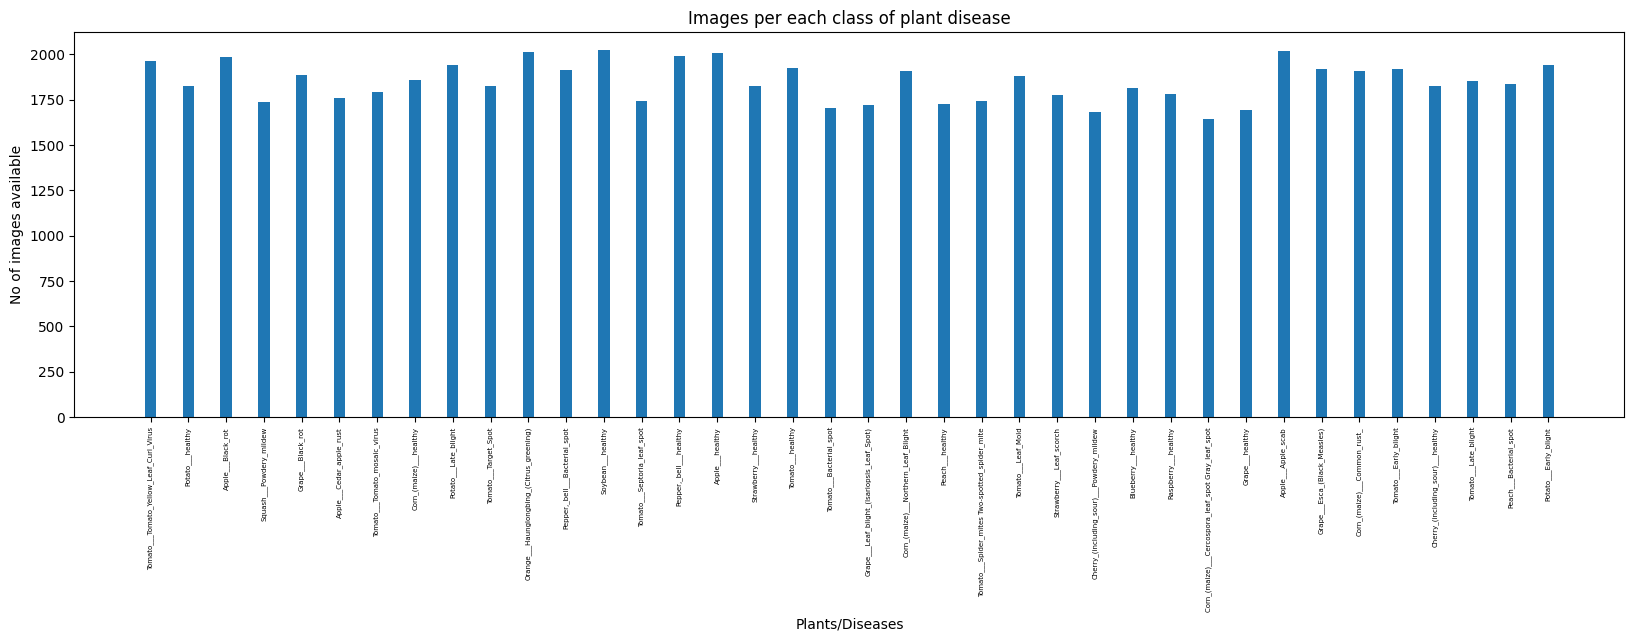

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

Our dataset is balanced we can continue to process.

In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

### Using GPU

In [ ]:
#Check the gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Define callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
#tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
#tf.debugging.set_log_device_placement(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Create a MirroredStrategy.
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
print("Number of devices: {}".format(strategy.num_replicas_in_sync))# Define strategy

Number of devices: 1


* Transfer Learning Using MobileNet(trained on imagenet)

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = INPUT_SHAPE)

    base_model.trainable = False
    inputs = keras.Input(shape = INPUT_SHAPE)

    x = base_model(inputs, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(len(categories),
                              activation="softmax")(x)

    model = keras.Model(inputs = inputs,
                        outputs = x,
                        name="LeafDisease_MobileNet")
    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(),
                           'accuracy'])
    history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=EPOCH,
                    steps_per_epoch=150,
                    validation_steps=100,
                       callbacks=[early_stopping_callback])

17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/8
150/150 [==============================] - 380s 3s/step - loss: 1.8815 - categorical_accuracy: 0.4998 - accuracy: 0.4998 - val_loss: 0.7914 - val_categorical_accuracy: 0.7950 - val_accuracy: 0.7950
Epoch 2/8
150/150 [==============================] - 374s 2s/step - loss: 0.7626 - categorical_accuracy: 0.7821 - accuracy: 0.7821 - val_loss: 0.5459 - val_categorical_accuracy: 0.8503 - val_accuracy: 0.8503
Epoch 3/8
150/150 [==============================] - 394s 3s/step - loss: 0.5638 - categorical_accuracy: 0.8346 - accuracy: 0.8346 - val_loss: 0.3888 - val_categorical_accuracy: 0.8900 - val_accuracy: 0.8900
Epoch 4/8
150/150 [==============================] - 379s 3s/step - loss: 0.4618 - categorical_accuracy: 0.8604 - accuracy: 0.8604 - val_loss: 0.3370 - val_categorical_accuracy: 0.9009 - val_accuracy: 0.9009
Epoch 5/8
150/150 [==============================] - 386s 3s/step - loss: 0.4117 - categorical_accuracy

### Save the Model

In [ ]:
model.save('leafclassifier.keras')
model.save('your_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Observing the model performance

In [ ]:
acc= history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
val_acc

[0.7950000166893005,
 0.8503124713897705,
 0.8899999856948853,
 0.9009374976158142,
 0.9106249809265137,
 0.9121875166893005,
 0.9196875095367432,
 0.910937488079071]

Text(0.5, 1.0, 'Training and Validation Accuracy')

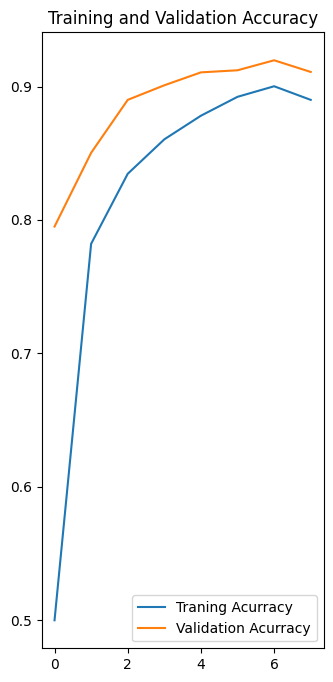

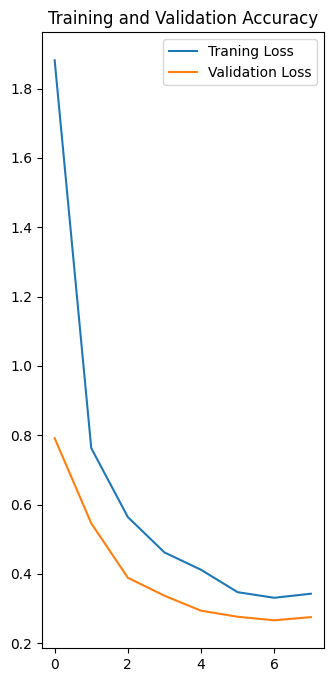

In [ ]:
plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label ='Traning Acurracy')
plt.plot(range(EPOCH), val_acc, label ='Validation Acurracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# plt.axis("off")

plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), loss, label ='Traning Loss')
plt.plot(range(EPOCH), val_loss, label ='Validation Loss')
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

### Now run inference on few sample images

In [ ]:
os.listdir('/kaggle/input/new-plant-diseases-dataset/test/test')

['AppleCedarRust4.JPG',
 'PotatoEarlyBlight3.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoHealthy4.JPG',
 'PotatoHealthy2.JPG',
 'TomatoYellowCurlVirus6.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoHealthy1.JPG',
 'AppleScab1.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'AppleCedarRust1.JPG',
 'CornCommonRust2.JPG',
 'PotatoEarlyBlight1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'PotatoEarlyBlight5.JPG',
 'CornCommonRust1.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'PotatoEarlyBlight2.JPG',
 'TomatoHealthy3.JPG',
 'PotatoHealthy1.JPG',
 'AppleCedarRust3.JPG',
 'TomatoEarlyBlight4.JPG',
 'AppleScab3.JPG',
 'TomatoEarlyBlight6.JPG',
 'CornCommonRust3.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'PotatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight3.JPG',
 'AppleCedarRust2.JPG',
 'AppleScab2.JPG']

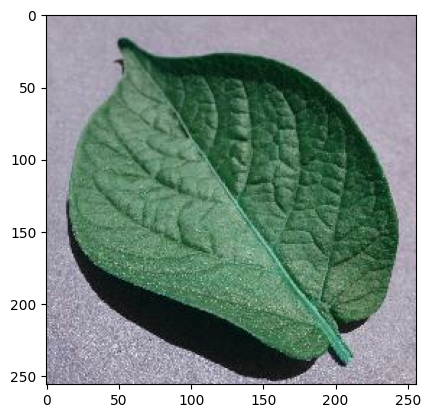

In [ ]:
img = cv2.imread('/kaggle/input/new-plant-diseases-dataset/test/test/PotatoHealthy1.JPG')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (224,224))
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 871ms/step


In [ ]:
yhat

array([[4.4138829e-07, 1.6964739e-06, 9.9091464e-09, 2.3291796e-04,
        3.4796807e-04, 7.2499320e-06, 8.7125891e-06, 6.0125892e-08,
        1.2254299e-06, 2.1505107e-07, 4.4759300e-08, 6.2154193e-09,
        2.9112202e-09, 5.6561715e-09, 8.7230019e-09, 5.0446655e-05,
        1.7448018e-07, 9.8969365e-05, 8.2992927e-05, 1.5128187e-04,
        9.0991953e-06, 1.8949817e-03, 9.9288625e-01, 8.4580182e-07,
        4.0662140e-03, 2.6743138e-10, 2.0704920e-09, 4.1748481e-06,
        3.6829539e-07, 7.5576258e-06, 1.3311949e-05, 9.4093321e-06,
        7.4179781e-07, 6.2400148e-05, 3.4568500e-05, 2.1988000e-05,
        1.8743008e-06, 1.7284134e-06]], dtype=float32)

In [ ]:
predicted_class_index = yhat.argmax()

In [ ]:
predicted_class_index

22

In [ ]:
#predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding class label using the class indices dictionary
class_labels = list(train_data.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

Potato___healthy


In [ ]:
class_labels= ['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
plant_list = [" ".join(filter(None, i.split('_'))) for i in class_labels]

In [ ]:
" ".join(filter(None, 'Tomato___Target_Spot'.split('_')))

'Tomato Target Spot'

In [ ]:
# Regular expression to match text inside parentheses
import re
pattern = r'\(.*?\)'

# Removing text inside parentheses for each item in the list
class_labels = [re.sub(pattern, '', item).strip() for item in plant_list]

print(class_labels)

['Apple Apple scab', 'Apple Black rot', 'Apple Cedar apple rust', 'Apple healthy', 'Blueberry healthy', 'Cherry  Powdery mildew', 'Cherry  healthy', 'Corn  Cercospora leaf spot Gray leaf spot', 'Corn  Common rust', 'Corn  Northern Leaf Blight', 'Corn  healthy', 'Grape Black rot', 'Grape Esca', 'Grape Leaf blight', 'Grape healthy', 'Orange Haunglongbing', 'Peach Bacterial spot', 'Peach healthy', 'Pepper, bell Bacterial spot', 'Pepper, bell healthy', 'Potato Early blight', 'Potato Late blight', 'Potato healthy', 'Raspberry healthy', 'Soybean healthy', 'Squash Powdery mildew', 'Strawberry Leaf scorch', 'Strawberry healthy', 'Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two-spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato Yellow Leaf Curl Virus', 'Tomato Tomato mosaic virus', 'Tomato healthy']


In [ ]:
def predict(model, img, class_labels):
    # convert image to image array
    img = cv2.imread(img)
    resize = tf.image.resize(img, (224,224))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    predicted_class_index = yhat.argmax()

    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

In [ ]:
predict(model=model, img='/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust2.JPG', class_labels=class_labels)

1/1 [==============================] - 0s 134ms/step


'Apple Cedar apple rust'